# Backpropagation

## Recap: Multi-Layer Perceptron (MLP)
Recall that a perceptron can only distinguish between members of class A and members of class B **if** these **classes are linearly separable**.

In the 1960, this led to a search for classification approaches using **multi-layer perceptrons**. The researchers found that an MLP with just **2 adjustable layers** of weights can correctly classify **any finite number of classes** if there is a sufficient number of "hidden" perceptrons in the layer mediating between the input vector and the output unit.

Unfortunately, for fewer hidden perceptrons than cases to be learned, no even moderately efficient algorithm for systematically computing the weights could be found. Eventually, researchers came up with an algorithm known as **backpropagation** (**BP**) based on the concept of derivation known from calculus.

## Computing Derivatives

Let's define some arbitrary function $f$, say $f(x) = 3x^2 - 4x + 5$. In code, the function looks like this:

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return 3*x**2 - 4*x + 5

To determine how much the change in $x$ affects the function value $f(x)$, we compute $f$'s derivative and set in $x$. The derivative is defined as (source: [Wikipedia](https://en.wikipedia.org/wiki/Derivative)):

$$\lim_{h\rightarrow 0} \frac{f(x+h) - f(x)}{h}$$

So, the following code computes the rate of change for $f(x)$ with $x=3$:

In [5]:
x = 3.0
h = 0.001
print(f"f(x+h)= {f(x+h)}, f(x)= {f(x)}, dy/dx= {(f(x+h) - f(x)) / h}")

f(x+h)= 20.014003000000002, f(x)= 20.0, dy/dx= 14.00300000000243


## Backpropagation

Now, let's define the mathematical expression which we will use to illustrate BP:

$$L = ((a\cdot b) + c) \cdot f$$

We will refer to the intermediate terms as:

$$d = a \cdot b$$

and

$$e = d + c$$

So, using the intermediate results, we can express our equation as:

$$L = e \cdot f$$
$$e = d + c$$
$$d = a \cdot b$$

Our goal is to determine how the change of each variable affects the function value $L(a, b, c, f)$.

### Step 1

Clearly, the derivative of $L$ with respect to $L$ is 1. Since $L = e \cdot f$, we compute the derivative of $L$ with respect to $e$ as:

$$\frac{dL}{de} = \frac{(e+h)\cdot f - e \cdot f}{h} = \frac{e \cdot f + h \cdot f - e \cdot f}{h} = \frac{h \cdot f}{h} = f$$

By analogy, the derivate of $L$ with respect to $f$ is:

$$\frac{dL}{df} = \frac{e \cdot (f + h) - e \cdot f}{h} = \frac{e \cdot f + e \cdot h - e \cdot f}{h} = \frac{e \cdot h}{h} = e$$

### Step 2

To compute the derivative of $L$ with respect to, say, $c$, we need to apply the **chain rule** from calculus. The chain rule says that if a variable $z$ depends on variable $y$, which, in turn, depends on the variable $x$, then $z$'s dependence on $x$ is:

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$

So, if we want to find $\frac{dL}{dc}$, the chain rule tells us that we need to compute:

$$\frac{dL}{dc} = \frac{dL}{de} \cdot \frac{de}{dc}$$

Because $e = d + c$, we have:

$$\frac{de}{dc} = 1$$

and

$$\frac{de}{dd} = 1$$

As a result:

$$\frac{dL}{dc} = \frac{dL}{de} \cdot \frac{de}{dc} = \frac{dL}{de} \cdot 1 = \frac{dL}{de}$$

and

$$\frac{dL}{dd} = \frac{dL}{de} \cdot \frac{de}{dd} = \frac{dL}{de} \cdot 1 = \frac{dL}{de}$$

In other words, the **addition** operation simply **"routes" the gradient** (.i.e., the partial derivative $\frac{dL}{de}$) to the nodes $e$ and $c$.

### Step 3

To determine the gradient for $a$ and $b$, we also apply the chain rule to obtain:

$$\frac{dL}{da} = \frac{dL}{dd} \cdot \frac{dd}{da}$$

and

$$\frac{dL}{db} = \frac{dL}{dd} \cdot \frac{dd}{db}$$

## Illustrating BP

To summarise, **BP** is simply the **recursive application of the chain rule backwards through the propagation graph**. To illustrate this, we will now manually perform backpropagation for function $L$ by computing the partial derivatives and assigning them to the grad (gradient) variable of the corresponding nodes. The following code is based on [Andrej Karpathy's micrograd tutorial](https://github.com/karpathy/micrograd).

In [18]:
class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, (self, other), '+')
        else:
            return Value(self.data + other, (self,), '+')
        
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, (self, other), '*')
        else:
            return Value(self.data * other, (self,), '*')

In [19]:
# Code for visualizing the graph
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle node for it ('record')
        dot.node(name = uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # if the value was produced by an operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot

0.0
-2.0


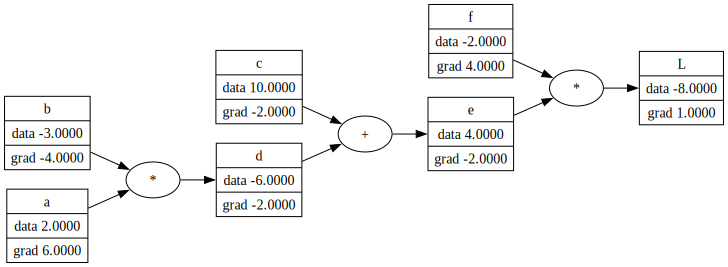

In [31]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'

# draw the graph of the function we defined above, including the derivative in respect to each variable
# based on the above observations, we now manually define the derivative of the loss function in respect to each variable
L.grad = 1.0 # because dL/dL = 1
print(e.grad)
e.grad = f.data
print(e.grad)

f.grad = e.data # because dL/df = e and e.data is the value of d for the argument values a = 2, b = -3, c = 10 
d.grad = e.grad * 1.0 # because due to chain rule, dL/dd = dL/de 
c.grad = e.grad * 1.0 # because, due to chain rule, dL/dc = dL/de
a.grad = d.grad * b.data # because, due to chain rule, dL/da = dL/de * de/da = dL/de * b and so it is simply the gradient of e times the value of b
b.grad = d.grad * a.data # because, due to chain rule, dL/db = dL/de * de/db = dL/de * a and so it is simply the gradient of e times the value of a

draw_dot(L)